In [1]:
import copy
from itertools import product
from classification_refined import classify
from processing import *
from readfiles import *
from decision import filter_summary
from subgraphclass import make_solver_summary
from sklearn.model_selection import train_test_split
from classification_refined import *
import networkx as nx
from readfiles import *
from metrics import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from readfiles import corresp_label_file
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
num = 84  # number of nodes in the graph
tri = int(num * (num + 1) * 0.5)  # we want only the upper diagonal due to symettry of connections
mat = np.triu_indices(84)
mews = '/home/skapoor/Thesis/gmwcs-solver'
metrics = ['balanced_accuracy', 'accuracy', 'f1_weighted', 'roc_auc_ovr_weighted']

In [3]:
target, feature, edge, solver_node_wts = 'NEOFAC_E', 'num_streamlines', 'pearson','const'
val, thresh, max_num_nodes, per = -0.01, 0, 10, 1.15
choice, classifier, refit_metric, feature_selection = 'random', 'ridge_reg', 'balanced_accuracy', 'baseline'
baseline_cases, self_loops = set(), False

In [4]:
# note: right now the matrix whole is not scaled, for computing the fscores and correlation coeff it has to be so.
y_train, y_test = computed_subjects(), test_subjects()
y_train_l, y_test_l = y_train[target], y_test[target]
X_train = generate_combined_matrix(tri, list(y_train.index))  # need to check indices till here then convert to numpy array
X_test = generate_test_data(tri, y_test.index)
X_train_l, X_test_l = edge_filtering(feature, X_train, X_test)

X, y = X_train_l.append(X_test_l), y_train_l.append(y_test_l)

In [5]:
assert list(X.index) == list(y.index)

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X, y)

print(skf)
results_solver = []
avg_thresh, self_loops = False, False
feature_selection = 'solver'
refit_metric = 'balanced_accuracy'
nodes = []
node_names = []
i =0 
param_grid = [{'alpha': [0.2,0.4, 0.5, 0.7]}]
for train_index, test_index in skf.split(X, y):
    i+=1
    #print("TRAIN:",len(train_index), train_index, "TEST:", len(test_index),test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    case = (classifier, target, choice, edge, feature_selection, feature, per, refit_metric, self_loops)
    # the baseline needs self loops command but the solver does not!
        # drop the diagonal indices from the columns
    strls_num = X_train
    if feature_selection == 'solver':
        print(classifier, feature_selection, choice, refit_metric, target, feature, edge,
              solver_node_wts)
        strls_num_l = strls_num.loc[X_train.index, :]
        if avg_thresh == True:
            strls_num_l = strls_num.mean(axis=0, skipna=True)
        else:
            # to check if there is atleast one or more streamlines for that particular feature for all subjects
            strls_num_l = strls_num_l.all()
        if i<4:
            keep_files = False
        else:
            keep_files = True
        X_train, X_test, output_graph = solver_pub(X_train, X_test, y_train, strls_num_l,feature, thresh,
                                                        val,
                                                        max_num_nodes, avg_thresh,
                                                        node_wts=solver_node_wts, target=target, 
                                                   edge=edge,keep_files=keep_files)
        
        nodes.append(list(output_graph.nodes))
        node_names.append(output_graph.node_labels)
        edge_wts = output_graph.edge_weights
        model = GridSearchCV(Ridge(), param_grid, scoring='r2',iid=True)
        #lr = LinearRegression()
        model.fit(X_train, y_train)
        print (model.best_params_)
        pred= model.predict(X_test)
        print(r2_score(y_test, pred))

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
ridge_reg solver random balanced_accuracy NEOFAC_E num_streamlines pearson const
{'alpha': 0.7}
-0.6109167455164843
ridge_reg solver random balanced_accuracy NEOFAC_E num_streamlines pearson const
{'alpha': 0.7}
-0.3308950212469035
ridge_reg solver random balanced_accuracy NEOFAC_E num_streamlines pearson const
{'alpha': 0.7}
0.0014278375335078364
ridge_reg solver random balanced_accuracy NEOFAC_E num_streamlines pearson const
{'alpha': 0.7}
-0.8190796140431453
ridge_reg solver random balanced_accuracy NEOFAC_E num_streamlines pearson const
{'alpha': 0.7}
-0.3873179031497236


In [7]:
a = np.sort(np.concatenate(nodes).flat)

d1 = {k-1:v for k,v in corresp_label_file('fs_default.txt').items() if k-1 in np.unique(a)}

d2 = {}
for k,v in zip(range(len(np.unique(a))), np.unique(a)):
    d2[v] = k

for i in range(len(a)):
    a[i] = d2[a[i]]

In [8]:
#plt.hist(a, bins=len(np.unique(a)))

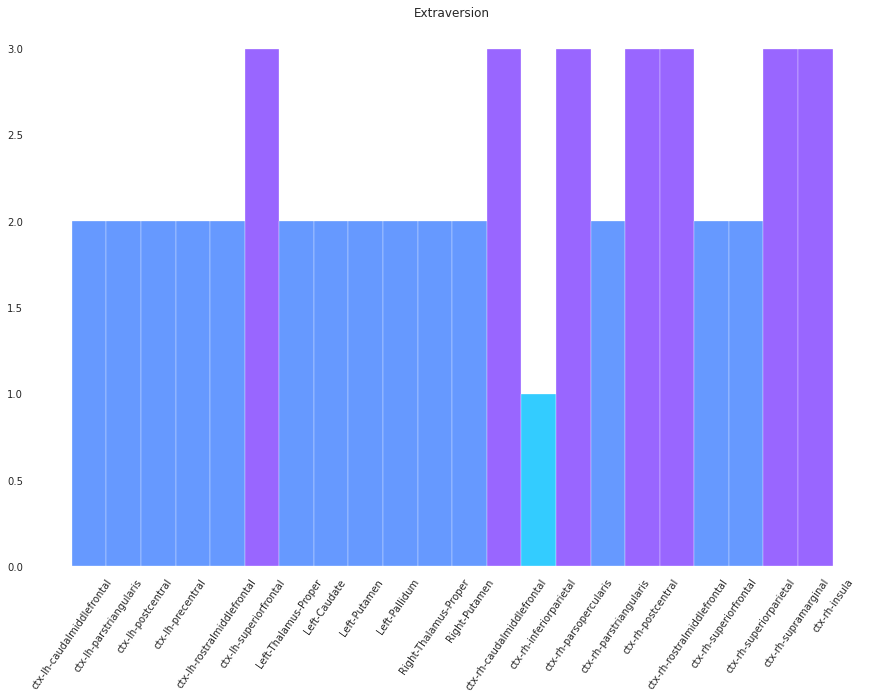

In [18]:
cm = plt.cm.get_cmap('cool')


fig, ax = plt.subplots(figsize=(15,10))
counts, bins, patches = ax.hist(a, bins=len(np.unique(a)))
for c, p in zip(counts, patches):
    plt.setp(p, 'facecolor', cm(c/5))
# Set the ticks to be at the edges of the bins.
plt.title('Extraversion')

plt.xticks(range(len(np.unique(a))),list(d1.values()), rotation=55)
plt.show()